Visualising the GPLVM model
--
*James Hensman, June 2016*

 - Sample from a simple GPLVM model
 - Fit a Bayesian GPLVM to the data
 - Visualise the model by plotting

In [55]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')
%matplotlib inline
import GPflow
import numpy as np
import tensorflow as tf
np.random.seed(0)

In [107]:
Q = 1 # latent dimension
D = 2 # output dimension
N = 100
lengthscale = 3.5
variance = 1.
noise_var = 0.001

#draw from the GPLVM model.
rng = np.random.RandomState(1) # 5 happens to be a pretty draw. 
X = rng.randn(N, Q)

Q_sm = 30
weights = np.ones(Q_sm)/(Q_sm * 1.)
lengthscales = .1 * np.random.rand(Q_sm, Q)
frequencies = 1. * np.random.rand(Q_sm, Q)

k = GPflow.ekernels.SM(Q, Q=Q_sm, weights=weights, lengthscales=lengthscales, frequencies=frequencies)
K = k.compute_K(X, X)
Y = rng.multivariate_normal(np.zeros(N), K + np.eye(N) * noise_var, D).T

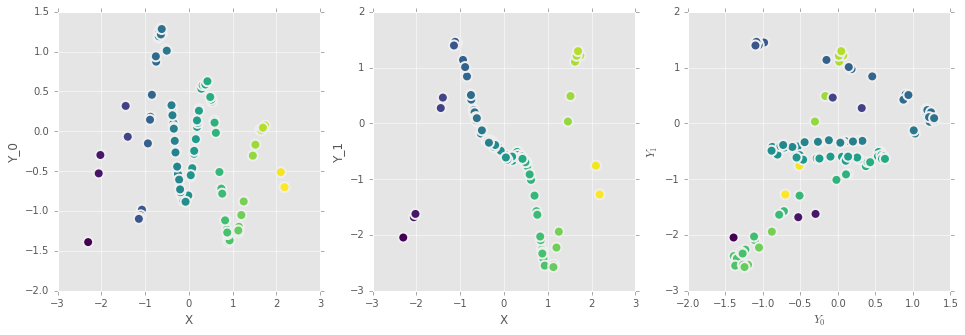

In [108]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, ax in enumerate(axes[:2]):
        ax.scatter(X, Y[:,i], 100, X, lw=2, cmap=plt.cm.viridis)
        ax.set_xlabel('X')
        ax.set_ylabel('Y_%i'%i)
axes[2].scatter(Y[:,0], Y[:,1], 100, X, lw=2, cmap=plt.cm.viridis)
axes[2].set_ylabel('$Y_1$')
axes[2].set_xlabel('$Y_0$')

([], <a list of 0 Text yticklabel objects>)

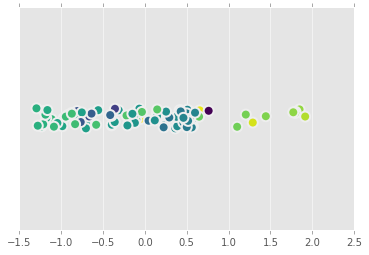

In [50]:
# compute the PCA projection of the data into 1D. 
XPCA = GPflow.gplvm.PCA_reduce(Y, 1)
jitter = np.random.rand(N)
plt.scatter(XPCA, jitter, 100, X, lw=2, cmap=plt.cm.viridis)
plt.ylim(-5, 6)
plt.yticks([])

In [51]:
# build a GPLVM init'd on the PCA solution

m = GPflow.gplvm.BayesianGPLVM(X_mean=XPCA, X_var=np.ones((N, Q)) * 0.01, Y=Y, kern=k, M=10, Z=np.random.randn(10, Q))
m.likelihood.variance = noise_var

2


/home/vincent/.virtualenvs/gpflow/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


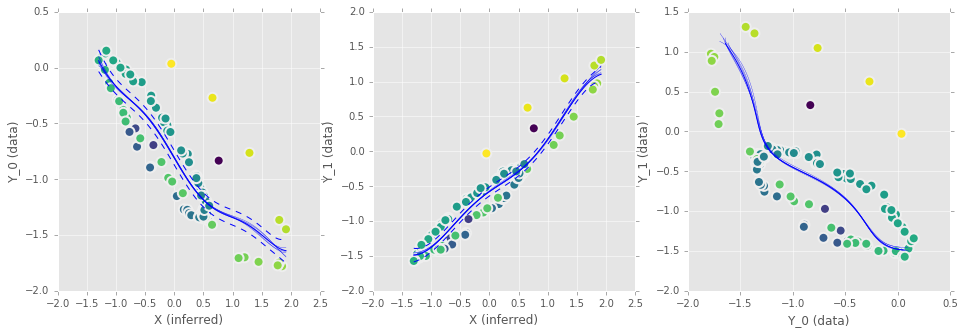

In [52]:
def plot():
    f, axes = plt.subplots(1, 3, figsize=(16, 5))
    Xtest = np.linspace(m.X_mean.value.min(), m.X_mean.value.max(), 100)[:,None]
    mu, var = m.predict_y(Xtest)
    # samples = m.predict_f_samples(X, 5) suffers numerical problem
    _, covar = m.predict_f_full_cov(Xtest)
    samples = [np.random.multivariate_normal(mu_i, var_i, 5) for mu_i, var_i in zip(mu.T, covar.T)]
    
    for i, ax in enumerate(axes[:2]):
        #ax.plot(m.X_mean.value, m.Y[:,i], 'kx')
        ax.plot(Xtest, mu[:,i], 'b')
        ax.plot(Xtest, mu[:,i] + 2*np.sqrt(var[:,i]), 'b--')
        ax.plot(Xtest, mu[:,i] - 2*np.sqrt(var[:,i]), 'b--')
        ax.scatter(m.X_mean.value, m.Y.value[:,i], 100, X, lw=2, cmap=plt.cm.viridis)
        ax.plot(Xtest.flatten(), samples[i].T, 'b', lw=0.3)
        
        ax.set_xlabel('X (inferred)')
        ax.set_ylabel('Y_%i (data)'%i)
    
    
    #axes[2].plot(m.Y[:,0], m.Y[:,1], 'kx')
    axes[2].scatter(m.Y.value[:,0], m.Y.value[:,1], 100, X, lw=2, cmap=plt.cm.viridis)
    axes[2].plot(mu[:,0], mu[:,1], 'b')
    for s1, s2 in zip(*samples):
        axes[2].plot(s1, s2, 'b', lw=0.3)
    axes[2].set_xlabel('Y_0 (data)')
    axes[2].set_ylabel('Y_1 (data)')

plot()
    

In [53]:
_ = m.optimize(maxiter=100, disp=1)

/home/vincent/.virtualenvs/gpflow/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


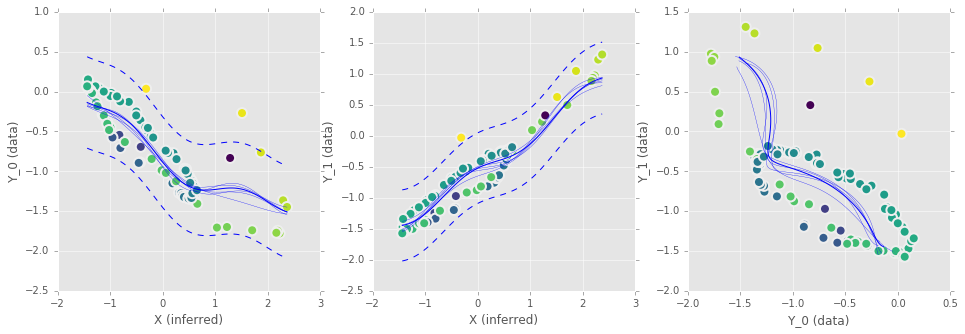

In [54]:
plot()